# Feasibility Challenges with Integers: Why Discrete Problems Are Harder

This notebook demonstrates why **feasibility is more challenging** with integer constraints than with continuous variables.

Understanding feasibility challenges is critical because:
- **Problems feasible with continuous variables can be infeasible with integers**
- **You cannot make tiny adjustments** to fix feasibility problems
- **The feasible region is much smaller** for discrete decisions
- **Some problems become unsolvable** when you account for integer constraints


## Key Concepts

**Feasibility** means finding solutions that meet all constraints.

**Continuous Optimization**:
- If slightly infeasible, can adjust by tiny amounts (0.1%)
- Large feasible region with many options
- Easy to fix small violations

**Discrete Optimization**:
- Cannot make tiny adjustments - must make jumps
- Small feasible region with few options
- Hard to fix violations - may need to jump to completely different solution
- Some problems become infeasible when you require whole numbers

**Critical insight**: A problem that is feasible with continuous variables might be infeasible with integer variables. You cannot always round a continuous solution to get a feasible integer solution.


## Scenario: Staffing Problem with Tight Constraints

You manage a healthcare system with 10 clinics. Each clinic needs at least 2 nurses during day shifts.

**The Problem**:
- Each clinic needs at least 2 nurses
- You have budget for 25 nurses total
- 10 clinics × 2 nurses = 20 nurses minimum needed
- Budget allows 25 nurses

**The Challenge**: 
- Continuous model: Allocate 2.5 nurses per clinic = 25 total (feasible!)
- Integer model: Must allocate whole nurses. Can you satisfy all constraints?


## Step 1: Install Required Packages (Colab)


In [1]:
# Install pulp package (required for optimization)
%pip install pulp -q



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, value, LpStatus

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)


## Step 3: Define Problem Data


In [3]:
# Problem data
num_clinics = 10
min_nurses_per_clinic = 2
total_budget_nurses = 25

print("PROBLEM DATA:")
print(f"  Number of clinics: {num_clinics}")
print(f"  Minimum nurses per clinic: {min_nurses_per_clinic}")
print(f"  Total budget (nurses): {total_budget_nurses}")
print(f"\nMinimum needed: {num_clinics} × {min_nurses_per_clinic} = {num_clinics * min_nurses_per_clinic} nurses")
print(f"Budget available: {total_budget_nurses} nurses")
print(f"  Feasible with continuous? {num_clinics * min_nurses_per_clinic <= total_budget_nurses}")


PROBLEM DATA:
  Number of clinics: 10
  Minimum nurses per clinic: 2
  Total budget (nurses): 25

Minimum needed: 10 × 2 = 20 nurses
Budget available: 25 nurses
  Feasible with continuous? True


## Step 4: Model as Continuous (Feasible)


In [4]:
# Continuous model
model_cont = LpProblem("Staffing_Continuous", LpMinimize)
clinics = [f"Clinic_{i+1}" for i in range(num_clinics)]

# Continuous variables
nurses_cont = {}
for c in clinics:
    nurses_cont[c] = LpVariable(f"nurses_{c}", lowBound=0, cat='Continuous')

# Objective: Minimize total nurses (or could be cost)
model_cont += lpSum([nurses_cont[c] for c in clinics]), "Total_Nurses"

# Constraints: Each clinic needs at least min_nurses_per_clinic
for c in clinics:
    model_cont += nurses_cont[c] >= min_nurses_per_clinic, f"Min_{c}"

# Budget constraint
model_cont += lpSum([nurses_cont[c] for c in clinics]) <= total_budget_nurses, "Budget"

# Solve
model_cont.solve()
status_cont = LpStatus[model_cont.status]

print("CONTINUOUS MODEL:")
print("=" * 60)
print(f"Status: {status_cont}")

if status_cont == 'Optimal':
    total_cont = sum([value(nurses_cont[c]) for c in clinics])
    avg_cont = total_cont / num_clinics
    print(f"Total nurses: {total_cont:.2f}")
    print(f"Average per clinic: {avg_cont:.2f}")
    print(f"\n✓ FEASIBLE - Can allocate {avg_cont:.2f} nurses per clinic")
else:
    print("✗ INFEASIBLE")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/39a673852d3c4b8ebae713e1d5baba82-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/39a673852d3c4b8ebae713e1d5baba82-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 16 COLUMNS
At line 47 RHS
At line 59 BOUNDS
At line 60 ENDATA
Problem MODEL has 11 rows, 10 columns and 20 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-11) rows, 0 (-10) columns and 0 (-20) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 20
After Postsolve, objective 20, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 20 - 0 iterations time 0.002, Presolve 0.00
Option for printin

## Step 5: Model as Integer (Check Feasibility)


In [5]:
# Integer model
model_int = LpProblem("Staffing_Integer", LpMinimize)

# Integer variables
nurses_int = {}
for c in clinics:
    nurses_int[c] = LpVariable(f"nurses_{c}", lowBound=0, cat='Integer')

# Same objective and constraints
model_int += lpSum([nurses_int[c] for c in clinics]), "Total_Nurses"
for c in clinics:
    model_int += nurses_int[c] >= min_nurses_per_clinic, f"Min_{c}"
model_int += lpSum([nurses_int[c] for c in clinics]) <= total_budget_nurses, "Budget"

# Solve
model_int.solve()
status_int = LpStatus[model_int.status]

print("INTEGER MODEL:")
print("=" * 60)
print(f"Status: {status_int}")

if status_int == 'Optimal':
    total_int = sum([int(value(nurses_int[c])) for c in clinics])
    solution_int = {c: int(value(nurses_int[c])) for c in clinics}
    print(f"Total nurses: {total_int}")
    print(f"\nAllocation per clinic:")
    for c in clinics:
        print(f"  {c}: {solution_int[c]} nurses")
    print(f"\n✓ FEASIBLE with integers")
else:
    print(f"\n✗ INFEASIBLE with integers!")
    print(f"  Continuous model was feasible, but integer model is not.")
    print(f"  Why? Cannot allocate fractional nurses.")
    print(f"  Minimum needed: {num_clinics} × {min_nurses_per_clinic} = {num_clinics * min_nurses_per_clinic}")
    print(f"  Budget allows: {total_budget_nurses}")
    print(f"  Gap: {num_clinics * min_nurses_per_clinic - total_budget_nurses} nurses")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/73444edc74574db98e29c584635c011e-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/73444edc74574db98e29c584635c011e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 16 COLUMNS
At line 67 RHS
At line 79 BOUNDS
At line 90 ENDATA
Problem MODEL has 11 rows, 10 columns and 20 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 20 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 20 to -1.79769e+308
Probing was tried 0 times and created 0 cut

## Step 6: Visualize Feasible Regions


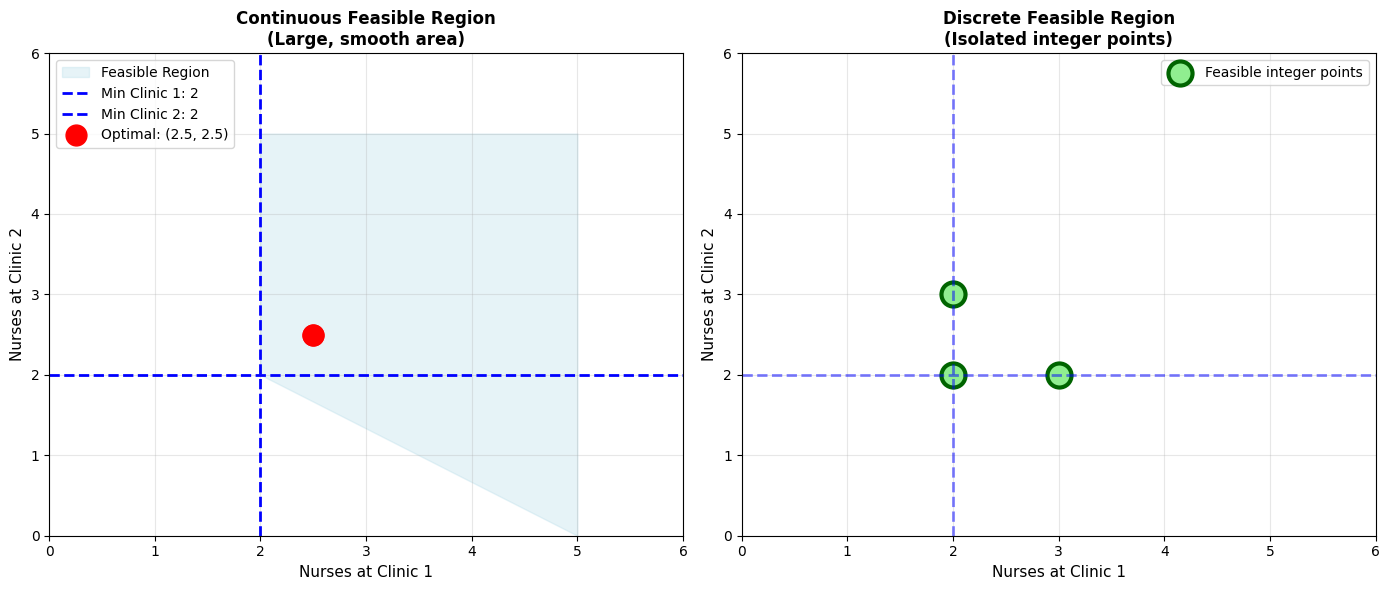


Key Observation:
  Continuous: Large feasible region
  Discrete: Only 3 feasible points: [(np.int64(2), np.int64(2)), (np.int64(2), np.int64(3)), (np.int64(3), np.int64(2))]
  Discrete feasible region is much smaller!


In [6]:
# Visualize feasible regions for a simplified 2-clinic example
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Simplified: 2 clinics, min 2 each, budget 5
clinic1_range = np.arange(0, 6)
clinic2_range = np.arange(0, 6)

# Continuous feasible region
ax1.fill_between([2, 5], [2, 0], [5, 5], alpha=0.3, color='lightblue', label='Feasible Region')
ax1.axvline(x=2, color='blue', linestyle='--', linewidth=2, label='Min Clinic 1: 2')
ax1.axhline(y=2, color='blue', linestyle='--', linewidth=2, label='Min Clinic 2: 2')
ax1.plot([2.5, 2.5], [2.5, 2.5], 'ro', markersize=15, label='Optimal: (2.5, 2.5)')
ax1.set_xlabel('Nurses at Clinic 1', fontsize=11)
ax1.set_ylabel('Nurses at Clinic 2', fontsize=11)
ax1.set_title('Continuous Feasible Region\n(Large, smooth area)', fontweight='bold', fontsize=12)
ax1.set_xlim(0, 6)
ax1.set_ylim(0, 6)
ax1.legend()
ax1.grid(alpha=0.3)

# Discrete feasible points
discrete_points = []
for c1 in clinic1_range:
    for c2 in clinic2_range:
        if c1 >= 2 and c2 >= 2 and (c1 + c2) <= 5:
            discrete_points.append((c1, c2))

ax2.scatter([p[0] for p in discrete_points], [p[1] for p in discrete_points], 
            s=300, c='lightgreen', edgecolors='darkgreen', linewidths=3, 
            label='Feasible integer points', zorder=2)
ax2.axvline(x=2, color='blue', linestyle='--', linewidth=2, alpha=0.5)
ax2.axhline(y=2, color='blue', linestyle='--', linewidth=2, alpha=0.5)
ax2.set_xlabel('Nurses at Clinic 1', fontsize=11)
ax2.set_ylabel('Nurses at Clinic 2', fontsize=11)
ax2.set_title('Discrete Feasible Region\n(Isolated integer points)', fontweight='bold', fontsize=12)
ax2.set_xlim(0, 6)
ax2.set_ylim(0, 6)
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nKey Observation:")
print(f"  Continuous: Large feasible region")
print(f"  Discrete: Only {len(discrete_points)} feasible points: {discrete_points}")
print(f"  Discrete feasible region is much smaller!")


## Step 7: Why You Can't Make Small Adjustments


In [7]:
# Demonstrate why small adjustments don't work
print("WHY SMALL ADJUSTMENTS DON'T WORK:")
print("=" * 60)

# Scenario: Need 3.2 nurses per clinic, but must use whole numbers
target_per_clinic = 3.2
num_clinics_example = 5
total_needed = target_per_clinic * num_clinics_example

print(f"\nScenario: {num_clinics_example} clinics, need {target_per_clinic} nurses per clinic")
print(f"  Continuous solution: {total_needed} total nurses (feasible)")

# Try rounding
round_down = int(target_per_clinic) * num_clinics_example
round_up = (int(target_per_clinic) + 1) * num_clinics_example

print(f"\n  Round DOWN to {int(target_per_clinic)} per clinic:")
print(f"    Total: {round_down} nurses")
print(f"    Per clinic: {round_down / num_clinics_example} nurses")
print(f"    Problem: Each clinic gets less than needed!")

print(f"\n  Round UP to {int(target_per_clinic) + 1} per clinic:")
print(f"    Total: {round_up} nurses")
print(f"    Per clinic: {round_up / num_clinics_example} nurses")
print(f"    Problem: May exceed budget or other constraints!")

print(f"\n  Key Insight: Cannot adjust by 0.2 nurses - must jump by whole numbers")
print(f"    This makes feasibility much harder!")


WHY SMALL ADJUSTMENTS DON'T WORK:

Scenario: 5 clinics, need 3.2 nurses per clinic
  Continuous solution: 16.0 total nurses (feasible)

  Round DOWN to 3 per clinic:
    Total: 15 nurses
    Per clinic: 3.0 nurses
    Problem: Each clinic gets less than needed!

  Round UP to 4 per clinic:
    Total: 20 nurses
    Per clinic: 4.0 nurses
    Problem: May exceed budget or other constraints!

  Key Insight: Cannot adjust by 0.2 nurses - must jump by whole numbers
    This makes feasibility much harder!


## Summary: Feasibility Challenges with Integers

**Key Points**:
- Problems feasible with continuous variables can be infeasible with integers
- You cannot make tiny adjustments to fix feasibility problems
- The feasible region is much smaller for discrete decisions
- Some problems become unsolvable when you require whole numbers

**Why This Matters**:
- Don't assume continuous feasibility implies integer feasibility
- May need to relax constraints or adjust objectives
- Understanding this helps you recognize when problems are truly infeasible
- Helps you communicate why certain requirements cannot be met

**Critical Takeaway**:
- Integer constraints make feasibility harder
- Always check feasibility with integer constraints, not just continuous
- Be prepared to adjust constraints or objectives when problems are infeasible
